In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split

# Day 1 
**Logistic Regression: Train, evaluate with 5-fold CV, log metrics.**

In [34]:
main = pd.read_csv('./data/dirty_data.csv')
Y = main['Machine failure']
selected_features = pd.read_csv('./data/selected_features.csv')

# Dropping the unwanted columns
X = selected_features.drop(columns=["Torque [Nm]", "Rotational speed [rad/s]"])

In [35]:
# Step 1: Spliting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

In [36]:
# Step 2: Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [37]:
# Step 3: Training the model
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [38]:
# Step 4: Make predictions
y_pred = model.predict(X_test_scaled)

In [39]:
# Step 5: Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Accuracy: 0.7305
Precision: 0.09743589743589744
Recall: 0.8382352941176471
F1 Score: 0.17457886676875958


In [40]:
print(Y.value_counts())

Machine failure
0    9661
1     339
Name: count, dtype: int64


In [41]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[1404  528]
 [  11   57]]


# Day 2

In [42]:
from sklearn.neighbors import KNeighborsClassifier
#K-nearest neighbors

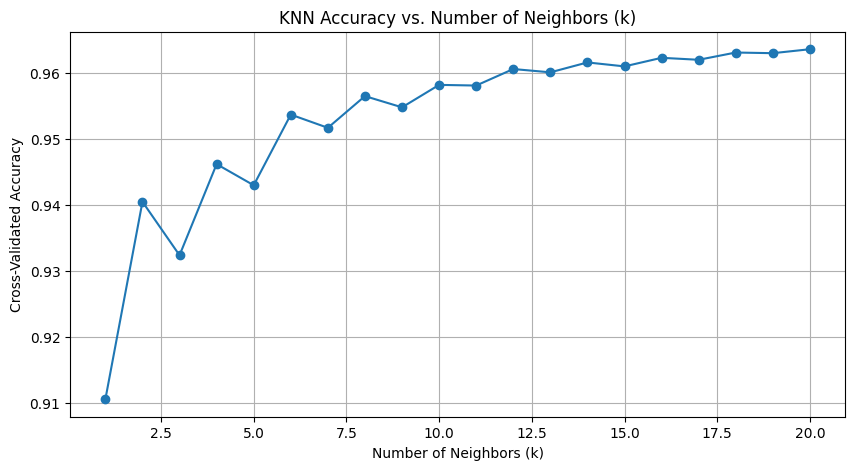

In [43]:
# scalling X first
X_scaled = scaler.fit_transform(X)

accuracies = []
k_range = range(1, 21)

#different values of k
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_scaled, Y, cv=5, scoring='accuracy')
    accuracies.append(scores.mean())

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(k_range, accuracies, marker='o')
plt.title("KNN Accuracy vs. Number of Neighbors (k)")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Cross-Validated Accuracy")
plt.grid(True)
plt.show()

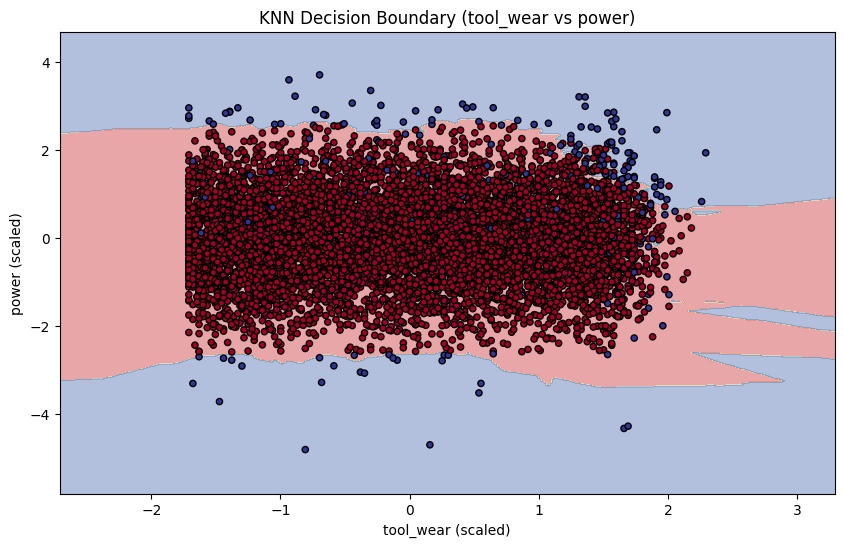

In [44]:
# KNN Decision Boundary Visualization
X = selected_features[['Tool wear [min]', 'Power [W]']]
y = main['Machine failure']

# 2. Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# 3. Fit a KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# 4. Plot decision boundary
h = 0.02  # step size in the mesh
x_min, x_max = X_train_scaled[:, 0].min() - 1, X_train_scaled[:, 0].max() + 1
y_min, y_max = X_train_scaled[:, 1].min() - 1, X_train_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# 5. Plot
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdYlBu)
plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, cmap=plt.cm.RdYlBu, edgecolor='k', s=20)
plt.title("KNN Decision Boundary (tool_wear vs power)")
plt.xlabel("tool_wear (scaled)")
plt.ylabel("power (scaled)")
plt.show()

In [45]:
# predicting with KNN
y_pred_knn = knn.predict(X_test_scaled)

#Evaluating the model
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Precision:", precision_score(y_test, y_pred_knn))
print("Recall:", recall_score(y_test, y_pred_knn))
print("F1 Score:", f1_score(y_test, y_pred_knn))

Accuracy: 0.981
Precision: 0.8285714285714286
Recall: 0.47540983606557374
F1 Score: 0.6041666666666666


# Day 3

In [46]:
#function to automate model training and evaluation
class Model():
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    #Split and scale
    def splitAndScale(self):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.Y, test_size=0.2, random_state=42)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        return { 'X_train': X_train_scaled, 'X_test': X_test_scaled, 'Y_train': y_train, 'Y_test': y_test }
    
    #train model and evaluate
    def trainAndEvaluate(self, model, X_test, Y_test, X_train, Y_train):
        model.fit(X_train, Y_train)

        # predicting with model
        Y_pred = model.predict(X_test)

        #confusion matrix
        cm = confusion_matrix(Y_test, Y_pred)

        #Evaluate and return parameters
        return {
            'accuracy': accuracy_score(Y_test, Y_pred),
            'precision': precision_score(Y_test, Y_pred, zero_division=0),
            'recall': recall_score(Y_test, Y_pred),
            'f1': f1_score(Y_test, Y_pred),
            'Confusion matrix': cm,
            'model_name': model.__class__.__name__,  # name as string
            'model_obj': model,                      # actual model object
            'params': model.get_params()
        }
    
    def run(self, model):
        data = self.splitAndScale()
        return self.trainAndEvaluate(
            model, 
            data['X_test'], data['Y_test'], 
            data['X_train'], data['Y_train'], 
        )


model = Model(X, y)
model_parameters = model.splitAndScale()
knn = KNeighborsClassifier(n_neighbors=7)
results = model.run(knn)
print(results)

{'accuracy': 0.9805, 'precision': 0.84375, 'recall': 0.4426229508196721, 'f1': 0.5806451612903226, 'Confusion matrix': array([[1934,    5],
       [  34,   27]]), 'model_name': 'KNeighborsClassifier', 'model_obj': KNeighborsClassifier(n_neighbors=7), 'params': {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}}


In [47]:
#saving model to a file
def log_results(results, filepath="model_log_2.csv"):
    # Convert params dict to string
    results_copy = results.copy()
    results_copy['params'] = str(results_copy['params'])
    results_copy['Confusion matrix'] = str(results_copy['Confusion matrix'])

    df = pd.DataFrame([results_copy])
    try:
        df.to_csv(filepath, mode='a', index=False, header=not pd.io.common.file_exists(filepath))
    except Exception as e:
        print("Logging failed:", e)

log_results(results)

In [48]:
#Random forest classifier
from sklearn.ensemble import RandomForestClassifier

X = selected_features.drop(columns=["Torque [Nm]", "Rotational speed [rad/s]"])
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight='balanced', #for imbalanced data
    random_state=42
)

model = Model(X, Y)
results_rf = model.run(rf)
print(results_rf)

{'accuracy': 0.9815, 'precision': 0.8157894736842105, 'recall': 0.5081967213114754, 'f1': 0.6262626262626263, 'Confusion matrix': array([[1932,    7],
       [  30,   31]]), 'model_name': 'RandomForestClassifier', 'model_obj': RandomForestClassifier(class_weight='balanced', random_state=42), 'params': {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}}


In [53]:
#trying with torque and rotational speed
X = selected_features.drop(columns=["Power [W]"])
model = Model(X, Y)
results_rf = model.run(rf)
print(results_rf)

{'accuracy': 0.9825, 'precision': 0.90625, 'recall': 0.47540983606557374, 'f1': 0.6236559139784946, 'Confusion matrix': array([[1936,    3],
       [  32,   29]]), 'model_name': 'RandomForestClassifier', 'model_obj': RandomForestClassifier(class_weight='balanced', random_state=42), 'params': {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}}


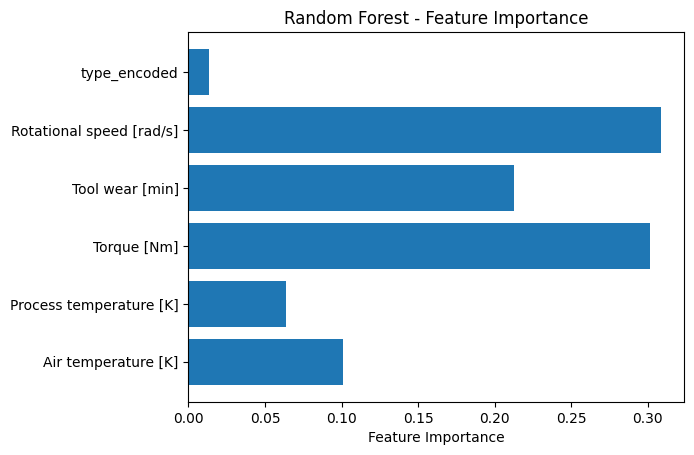

In [51]:
#feature importance
importances = results_rf['model_obj'].feature_importances_
features = ['Air temperature [K]', 'Process temperature [K]', 'Torque [Nm]', 'Tool wear [min]', 'Rotational speed [rad/s]', 'type_encoded']  # or add 'power' if used
plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest - Feature Importance")
plt.show()